# Assess Pipeline Performance
Measure various aspects of the performance of a pipeline run

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from glob import glob
import pandas as pd
import numpy as np
import re
import os

## Find All Runs
Get them with a glob and sort by name

In [2]:
runs = sorted(map(os.path.dirname, glob(os.path.join('**', 'results.json'))))
print(f'Found {len(runs)} runs with results')

Found 3 runs with results


Pick the latest

In [3]:
out_dir = runs[-1]

## Read the Log Files
We have a few different files with logs: the result file and the Python logging from the run at least

Optimization points evaluated

In [4]:
results = pd.read_json(os.path.join(out_dir, 'results.json'), lines=True)

The full application log

In [5]:
def parse_log(path):
    """Read in the log as a pandas DataFrame
    
    Args:
        path (str): Path to the log file
    Returns:
        (pd.DataFrame) Dataframe of the full log messages
    """
    
    # Read the entire file because some matches are multi-line
    with open(path) as fp:
        log_data = fp.read()
    
    # Apply a regex to get the message data
    log_regex = r'^(?P<time>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<file>\S+) - [A-Z]+ - (?P<message>[\S\s]+?(?=^\d|$))'
    log_entries = []
    for date, file, message in re.findall(log_regex, log_data, re.MULTILINE):
        log_entries.append({
            'datetime': datetime.strptime(date, '%Y-%m-%d %H:%M:%S,%f'),
            'file': file,
            'message': message.strip()
        })
    return pd.DataFrame(log_entries) 

In [6]:
log_data = parse_log(os.path.join(out_dir, 'run.log'))
log_data.head()

,datetime,file,message
0,2020-02-19 17:08:49.839,parsl.dataflow.dflow,Starting DataFlowKernel with config
1,2020-02-19 17:08:49.845,parsl.dataflow.dflow,Parsl version: 0.9.0
2,2020-02-19 17:08:49.845,parsl.dataflow.usage_tracking.usage,Tracking status: False
3,2020-02-19 17:08:49.845,parsl.dataflow.usage_tracking.usage,Testing mode : False
4,2020-02-19 17:08:49.845,parsl.dataflow.dflow,Run id is: 5d35c6bc-8490-415f-8e05-829883f4ba96


In [7]:
start_time = log_data['datetime'].min()
print(f'Application start time: {start_time}')

Application start time: 2020-02-19 17:08:49.839000


Parsl output log

In [8]:
def parse_parsl_log(path):
    """Read in the Parsl log as a pandas DataFrame
    
    Args:
        path (str): Path to the log file
    Returns:
        (pd.DataFrame) Dataframe of the full log messages
    """
    
    # Read the entire file because some matches are multi-line
    with open(path) as fp:
        log_data = fp.read()
    
    # Apply a regex to get the message data
    log_regex = r'^(?P<time>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{3}) (?P<file>\S+):\d+ \[[A-Z]+\]\s+(?P<message>[\S\s]+?(?=^\d|\Z))'
    log_entries = []
    for date, file, message in re.findall(log_regex, log_data, re.MULTILINE):
        log_entries.append({
            'datetime': datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f'),
            'file': file,
            'message': message.strip()
        })
    return pd.DataFrame(log_entries) 

In [9]:
parsl_log = parse_parsl_log(os.path.join(out_dir, 'run-info', '000', 'parsl.log'))
print(f'Read {len(parsl_log)} lines')

Read 2858 lines


Compute run times

In [10]:
parsl_log['runtime'] = parsl_log['datetime'].apply(lambda x: (x - start_time).total_seconds())
log_data['runtime'] = log_data['datetime'].apply(lambda x: (x - start_time).total_seconds())

In [11]:
results['runtime'] = results['time_result_received'].apply(datetime.fromtimestamp).apply(lambda x: (x - start_time).total_seconds())

## Compute the Optimizer Performance
Plot the best opimization performance as a function of number of evals and time

Compute the result output and run_time

In [12]:
results['output'] = results['value'].apply(lambda x: x['result'])

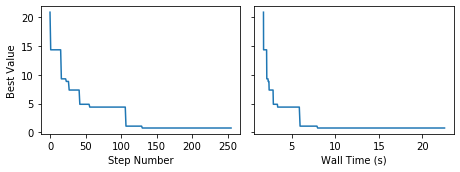

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5), sharey=True)

best_eval = results['output'].cummin()
axs[0].plot(results.index, best_eval)
axs[1].plot(results['runtime'], best_eval)

axs[0].set_ylabel('Best Value')
axs[0].set_xlabel('Step Number')
axs[1].set_xlabel('Wall Time (s)')
fig.tight_layout()

## Compute Actual Runtime vs Makespan for Results
We measure the runtime of actually invoking the task and how long from when the result is completed to when it is received

In [14]:
results['runtime'] = results['value'].apply(lambda x: x['runtime'])
results['makespan'] = results['time_result_received'] - results['time_created']
results['overhead'] = results['makespan'] - results['runtime']
results['overhead_frac'] = results['overhead'] / results['runtime']

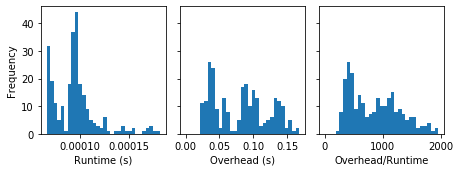

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6.5, 2.5))

top_val = np.percentile(results['overhead'], 95)
top_per = np.percentile(results['overhead_frac'], 95)
axs[0].hist(results['runtime'], bins=32)
axs[1].hist(results['overhead'], bins=np.linspace(0, top_val * 1.1, 32))
axs[2].hist(results['overhead_frac'], bins=np.linspace(0, top_per * 1.1, 32))

axs[0].set_xlabel('Runtime (s)')
axs[1].set_xlabel('Overhead (s)')
axs[2].set_xlabel('Overhead/Runtime')
axs[0].set_ylabel('Frequency')
fig.tight_layout()

## Evaluate How Busy Parsl Is
We are going to measure the queue length as a function of time by counting jobs in of the `target_function` and jobs out of `output_result`

In [16]:
job_status = parsl_log[parsl_log['message'].str.startswith('Task')].copy()
print(f'{len(job_status)} job status messages')

2057 job status messages


In [17]:
def determine_queue_change(message):
    """Mark whether a message corresponds to a message added to queue
    or completed from the queue
    
    1 corresponds to adding, -1 to finishing, and 0 otherwise
    
    Args:
        message (str): Task message
    Returns:
        (int) Whether the queue increased or decreased
    """
    
    if 'submitted for App target_function' in message:
        return 1
    elif 'launched on executor local_threads' in message:
        return -1
    else:
        return 0

In [18]:
job_status['queue_length'] = job_status['message'].apply(determine_queue_change).cumsum()

Plot the average queue length over time

In [19]:
rolling_queue = job_status.set_index('datetime').rolling('2s').mean()

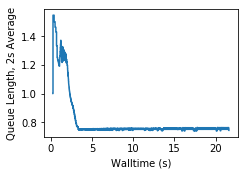

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.step(rolling_queue['runtime'], rolling_queue['queue_length'])

ax.set_ylabel('Queue Length, 2s Average')
ax.set_xlabel('Walltime (s)')
fig.tight_layout()

*Finding*: After a few seconds, the Thinker is no longer able to keep the queue stocked with work.

## Plot the Time Between Result Recieved and New Decision
Plot the amount of time the Thinker requires to submit its next idea

In [21]:
thinker_log = log_data.query('file=="Thinker"').iloc[4:]  # Get rid of first few messages, which are not from the loop

Compute time between received and next idea sent

In [22]:
thinker_log['sent'] = thinker_log['message'].str.contains('Sent')

In [23]:
decision_time = thinker_log.query('sent')['runtime'].values - thinker_log.query('not sent')['runtime'].values[:-1]

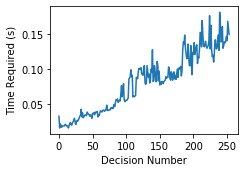

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(decision_time)

ax.set_xlabel('Decision Number')
ax.set_ylabel('Time Required (s)')
fig.tight_layout()

*Finding*: This is a result of the time to make the decision increasing, due to the increasing size of training data.